# Contents and why we need this lab

This lab is about implementing neural networks yourself before we start using other frameworks which hide some of the computation from you. It builds on the first lab where you derived the equations for neural network forward and backward propagation and gradient descent parameter updates. 

All the frameworks for deep learning you will meet from now on uses automatic differentiation (autodiff) so you don't have to code the backward step yourself. In this version of this lab you will develop your own autodif implementation. We also have a [version](https://github.com/DeepLearningDTU/02456-deep-learning-with-PyTorch/blob/master/2_Feedforward_NumPy/2.1-FNN-NumPy.ipynb) of this lab where you have to code the backward pass explicitly in Numpy.

# External sources of information

1. Jupyter notebook. You can find more information about Jupyter notebooks [here](https://jupyter.org/). It will come as part of the [Anaconda](https://www.anaconda.com/) Python installation. 
2. [NumPy](https://numpy.org/). Part of Anaconda distribution. If you already know how to program most things about Python and NumPy can be found through Google search.
3. [Nanograd](https://github.com/rasmusbergpalm/nanograd) is a minimalistic version of autodiff developed by Rasmus Berg Palm that we use for our framework.


# This notebook will follow the next steps:

1. Nanograd automatic differentiation framework
2. Finite difference method
3. Data generation
4. Defining and initializing the network
5. Forward pass
6. Training loop 
7. Testing your model
8. Further extensions

# Nanograd automatic differention framework

The [Nanograd](https://github.com/rasmusbergpalm/nanograd) framework defines a class Var which both holds a value and gradient value that we can use to store the intermediate values when we apply the chain rule of differentiation.

In [1]:
# Copy and pasted from https://github.com/rasmusbergpalm/nanograd/blob/main/nanograd.py

from math import exp, log, tanh

class Var:
    """
    A variable which holds a float and enables gradient computations.
    """

    def __init__(self, val: float, grad_fn=lambda: []):
        assert type(val) == float
        self.v = val
        self.grad_fn = grad_fn
        self.grad = 0.0

    def backprop(self, bp):
        self.grad += bp
        for input, grad in self.grad_fn():
            input.backprop(grad * bp)

    def backward(self):
        self.backprop(1.0)

    def __add__(self: 'Var', other: 'Var') -> 'Var':
        return Var(self.v + other.v, lambda: [(self, 1.0), (other, 1.0)])

    def __mul__(self: 'Var', other: 'Var') -> 'Var':
        #One variables takes the value of the other one as the gradient. 
        return Var(self.v * other.v, lambda: [(self, other.v), (other, self.v)]) 

    def __pow__(self, power):
        assert type(power) in {float, int}, "power must be float or int"
        return Var(self.v ** power, lambda: [(self, power * self.v ** (power - 1))])

    def __neg__(self: 'Var') -> 'Var':
        return Var(-1.0) * self

    def __sub__(self: 'Var', other: 'Var') -> 'Var':
        return self + (-other)

    def __truediv__(self: 'Var', other: 'Var') -> 'Var':
        return self * other ** -1

    def __repr__(self):
        return "Var(v=%.4f, grad=%.4f)" % (self.v, self.grad)

    def relu(self):
        return Var(self.v if self.v > 0.0 else 0.0, lambda: [(self, 1.0 if self.v > 0.0 else 0.0)])

A few examples illustrate how we can use this:

In [2]:
a = Var(3.0)
b = Var(5.0)
f = a * b

f.backward()

for v in [a, b, f]:
    print(v)

Var(v=3.0000, grad=5.0000)
Var(v=5.0000, grad=3.0000)
Var(v=15.0000, grad=1.0000)


In [3]:
a = Var(3.0)
b = Var(5.0)
c = a * b
d = Var(9.0)
e = a * d
f = c + e

f.backward()

for v in [a, b, c, d, e, f]:
    print(v)
    

Var(v=3.0000, grad=14.0000)
Var(v=5.0000, grad=3.0000)
Var(v=15.0000, grad=1.0000)
Var(v=9.0000, grad=3.0000)
Var(v=27.0000, grad=1.0000)
Var(v=42.0000, grad=1.0000)


## Exercise a) What is being calculated?

Explain briefly the output of the code? What is the expression we differentiate and with respect to what variables?

<span style="color:darkblue"> The code defines a class called **Var** with two main attributes: its value and its gradient. When calling the function `backward()`, the gradient of each variable being initialitatized with its respective value is computed. 

<span style="color:darkblue">For the example above, with the final expression being: $f=c+e=b·a+a·d$, each of the variables are differentiated with respect to $f$ (final value) to get their `grad` value. Below it is shown how it is computed. 
    
<span style="color:darkblue">
$$
\begin{align}
\frac{\partial f}{\partial a} &= \frac{\partial f}{\partial c} · \frac{\partial c}{\partial a}+\frac{\partial f}{\partial e} · \frac{\partial e}{\partial a}=  1·b + 1·d = 5+9 = 14\\
\frac{\partial f}{\partial b} &= \frac{\partial f}{\partial c} · \frac{\partial c}{\partial b}=1·a = 3 \\
\frac{\partial f}{\partial c} &= 1 \\
\frac{\partial f}{\partial d} &= \frac{\partial f}{\partial e} · \frac{\partial e}{\partial d} = 1·a=3 \\
\frac{\partial f}{\partial e} &= 1 \\
\end{align}
$$
    
</span>






## Exercise b) How does the backward function work?

You need to understand how the backward function calculates the gradients. We can use the two examples above to help with that.

Go through the following four steps and answer the questions on the way:

1. We represent the two expressions as graphs as shown below. Fill in the missing expressions for the different derivatives.

2. In the remainder consider the first expression. Make a schematic of the data structure which is generated when we define the expression for f. 

3. Then execute the backward function by hand to convince yourself that it indeed calculates the gradients with respect to the variables. 

4. Write down the sequence of calls to backprop.

<span style="color:darkblue"> The `backward()` function computes the different derivatives with respect to each variable added in the graph, as shown below. 

<span style="color:darkblue"> For the first graph, where $f=a·b$, it is first initialized two objects (`a` and `b`) of class `Var`, with gradients equal 0. Then, `backward()` is applied to f, being also a variable of class `Var`. Thus, `backprop()` is called three times and the gradient of each object is updated. 

``` 
a = Var(3.0) ----> v=3.0; grad=0.0
b = Var(5.0) ----> v=5.0; grad=0.0
f = a * b    ----> v=15.0; grad=0; [(a, 5.0), (b, 3.0)]

f.backward() ----> f.backprop(1.0)
             ----> f.grad=1.0
             ----> a.backprop(5.0)
             ----> a.grad=5.0
             ----> b.backprop(3.0)
             ----> b.grad=3.0
```
    
<span style="color:darkblue"> For the second graph, where $f=c+e=b·a+a·d$, different objects of class `Var` are intiailized with gradients equal 0. Then, `backward()` is applied to the final expression f, being also a variable of class `Var` and the derivatives with respect to each variable are computed. This time, `backprop()` is called seven times and the gradient of each object is updated. 

``` 
a = Var(3.0) ----> v=3.0; grad=0.0
b = Var(5.0) ----> v=5.0; grad=0.0
c = a * b    ----> v=15.0; grad=0; [(a, 5.0), (b, 3.0)]
d = Var(3.0) ----> v=9.0; grad=0.0
e = a * d    ----> v=27.0; grad=0; [(a, 9.0), (d, 3.0)]
f = c + e    ----> v=42.0; grad=0; [(c, 1.0), (e, 1.0)]

f.backward() ----> f.backprop(1.0)
             ----> f.grad=1.0
             ----> c.backprop(1.0)
             ----> c.grad=1.0
             ----> a.backprop(5.0)
             ----> a.grad=5.0
             ----> b.backprop(3.0)
             ----> b.grad=3.0
             ----> e.backprop(1.0)
             ----> e.grad=1.0
             ----> a.backprop(9.0)
             ----> a.grad=14.0
             ----> d.backprop(3.0)
             ----> d.grad=3.0

```  



    

In [1]:
# import logging
import graphviz

#logging.basicConfig(format='[%(levelname)s@%(name)s] %(message)s', level=logging.DEBUG)

#graphviz.__version__, graphviz.version()

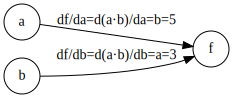

In [2]:
e1 = graphviz.Digraph('first expression',filename='fsm.gv')

e1.attr(rankdir='LR', size='8,5')

e1.attr('node', shape='circle')
e1.edge('a', 'f', label='df/da=d(a·b)/da=b=5')
e1.edge('b', 'f', label='df/db=d(a·b)/db=a=3')

e1

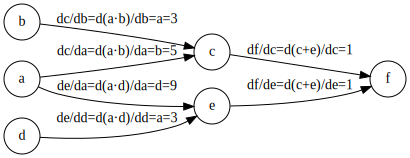

In [3]:
e2 = graphviz.Digraph('second expression', filename='fsm.gv')

e2.attr(rankdir='LR', size='8,5')

e2.attr('node', shape='circle')
e2.edge('a', 'c', label='dc/da=d(a·b)/da=b=5')
e2.edge('b', 'c', label='dc/db=d(a·b)/db=a=3')
e2.edge('a', 'e', label='de/da=d(a·d)/da=d=9')
e2.edge('d', 'e', label='de/dd=d(a·d)/dd=a=3')
e2.edge('c', 'f', label='df/dc=d(c+e)/dc=1')
e2.edge('e', 'f', label='df/de=d(c+e)/de=1')

e2

## Exercise c) What happens if we run backward again?

Try to execute the code below. Explain what happens.

In [5]:
f.backward()

for v in [a, b, c, d, e, f]:
    print(v)

Var(v=3.0000, grad=28.0000)
Var(v=5.0000, grad=6.0000)
Var(v=15.0000, grad=2.0000)
Var(v=9.0000, grad=6.0000)
Var(v=27.0000, grad=2.0000)
Var(v=42.0000, grad=2.0000)


<span style="color:navy"> By executing the function `backward()` again, we observed that the gradients for each variable are being updated, while the values are not changed since no more operations are added. 
This is because the gradients are computed again and added to the previous ones. 

``` 
a = Var(3.0) ----> v=3.0; grad=grad+14=28
b = Var(5.0) ----> v=5.0; grad=grad+3=6
c = Var(15.0) ---> v=15.0; grad=grad+1=2
d = Var(9.0) ----> v=9.0; grad=grad+3=6
e = Var(27.0) ---> v=27.0; grad=grad+1=2
f = Var(42.0) ---> v=42.0; grad=grad+1=2

``` 
</span>

## Exercise d) Zero gradient

We can zero the gradient by backpropagating a -1.0 as is shown in the example below. (If you have run backward multiple time then you also have to run the cell below an equal amount of times.) Explain what is going on.

## Exercise d) Zero gradient

We can zero the gradient by backpropagating a -1.0 as is shown in the example below. (If you have run backward multiple time then you also have to run the cell below an equal amount of times.) Explain what is going on.

In [6]:
a = Var(2.0)

for v in [a, b, c, d, e, f]:
    print(v)

print('\n')
f.backprop(-1.0)

for v in [a, b, c, d, e, f]:
    print(v)

Var(v=2.0000, grad=0.0000)
Var(v=5.0000, grad=6.0000)
Var(v=15.0000, grad=2.0000)
Var(v=9.0000, grad=6.0000)
Var(v=27.0000, grad=2.0000)
Var(v=42.0000, grad=2.0000)


Var(v=2.0000, grad=0.0000)
Var(v=5.0000, grad=3.0000)
Var(v=15.0000, grad=1.0000)
Var(v=9.0000, grad=3.0000)
Var(v=27.0000, grad=1.0000)
Var(v=42.0000, grad=1.0000)


<span style="color:darkblue"> By backpropagating with -1, it is exaclty doing the same operation as before but in negative values. Thus, we will have values below 0 for the gradients. In case we wanted to obtain the intial values of the gradient, we would backpropagating with +1. 
    
</span>

## Exercise e) Test correctness of derivatives with the finite difference method

Write a small function that uses [the finite difference method](https://en.wikipedia.org/wiki/Finite_difference_method) to numerically test that backpropation implementation is working. In short we will use
$$
\frac{\partial f(a)}{\partial a} \approx \frac{f(a+da)-f(a)}{da}
$$
for $da \ll 1$.

As an example, we could approximate the derivative of the function $f(a)=a^2$ in e.g. the value $a=4$ using the finite difference method. This amounts to inserting the relevant values and approximating the gradient $f'(4)$ with the fraction above. 


In [4]:
# f function - try to change the code to test other types of functions as well (such as different polynomials etc.)
def f_function(a):
  a = Var(a)
  b = Var(5.0)
  f = a * b
  f.backward()
  return a,b,f

for v in f_function(3.0):
  print(v)

# Insert your finite difference code here
def finite_difference(da=1e-10):
    """
    This function compute the finite difference between
    
    Input:
    da:          The finite difference                           (float)
    
    Output:
    finite_difference: numerical approximation to the derivative (float) 
    """
    
    a1,b1,fa_da = f_function(3.0+da)       
    a2,b2,fa = f_function(3.0)              
    finite_difference = (fa_da.v - fa.v) / da
    
    return finite_difference

print(finite_difference())

NameError: name 'Var' is not defined

# Create an artificial dataset to play with

We create a non-linear 1d regression task. The generator supports various noise levels and it creates train, validation and test sets. You can modify it yourself if you want more or less challenging tasks.

In [8]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

In [9]:
def data_generator(noise=0.1, n_samples=300, D1=True):
    # Create covariates and response variable
    if D1:
        X = np.linspace(-3, 3, num=n_samples).reshape(-1,1) # 1-D
        np.random.shuffle(X)
        y = np.random.normal((0.5*np.sin(X[:,0]*3) + X[:,0]), noise) # 1-D with trend
    else:
        X = np.random.multivariate_normal(np.zeros(3), noise*np.eye(3), size = n_samples) # 3-D
        np.random.shuffle(X)    
        y = np.sin(X[:,0]) - 5*(X[:,1]**2) + 0.5*X[:,2] # 3-D

    # Stack them together vertically to split data set
    data_set = np.vstack((X.T,y)).T
    
    train, validation, test = np.split(data_set, [int(0.35*n_samples), int(0.7*n_samples)], axis=0)
    
    # Standardization of the data, remember we do the standardization with the training set mean and standard deviation
    train_mu = np.mean(train, axis=0)
    train_sigma = np.std(train, axis=0)
    
    train = (train-train_mu)/train_sigma
    validation = (validation-train_mu)/train_sigma
    test = (test-train_mu)/train_sigma
    
    x_train, x_validation, x_test = train[:,:-1], validation[:,:-1], test[:,:-1]
    y_train, y_validation, y_test = train[:,-1], validation[:,-1], test[:,-1]

    return x_train, y_train,  x_validation, y_validation, x_test, y_test

In [10]:
D1 = True
x_train, y_train,  x_validation, y_validation, x_test, y_test = data_generator(noise=0.5, D1=D1)

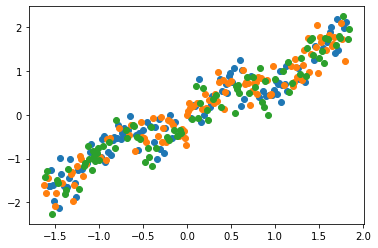

In [11]:
if D1:
    plt.scatter(x_train[:,0], y_train);
    plt.scatter(x_validation[:,0], y_validation);
    plt.scatter(x_test[:,0], y_test);
else:
    plt.scatter(x_train[:,1], y_train);
    plt.scatter(x_validation[:,1], y_validation);
    plt.scatter(x_test[:,1], y_test);
plt.show()

In [12]:
# convert from nparray to Var
def nparray_to_Var(x):
  if x.ndim==1:
    y = [[Var(float(x[i]))] for i in range(x.shape[0])] # always work with list of list
  else:
    y = [[Var(float(x[i,j])) for j in range(x.shape[1])] for i in range(x.shape[0])]
  return y
   
x_train = nparray_to_Var(x_train)
y_train = nparray_to_Var(y_train)
x_validation = nparray_to_Var(x_validation)
y_validation = nparray_to_Var(y_validation)
x_test = nparray_to_Var(x_test)
y_test = nparray_to_Var(y_test)



# Defining and initializing the network

The steps to create a feed forward neural network are the following:

1. **Number of hidden layer and hidden units**. We have to define the number of hidden units in each layer. The number of features in X and the output dimensionality (the size of Y) are given but the numbers in between are set by the researcher. Remember that for each unit in each layer beside in the input has a bias term.
2. **Activation functions** for each hidden layer. Each hidden layer in your list must have an activation function (it can also be the linear activation which is equivalent to identity function). The power of neural networks comes from non-linear activation functions that learn representations (features) from the data allowing us to learn from it. 
3. **Parameter initialization**. We will initialize the weights to have random values. This is done in practice by drawing pseudo random numbers from a Gaussian or uniform distribution. It turns out that for deeper models we have to be careful about how we scale the random numbers. This will be the topic of the exercise below. For now we will just use unit variance Gaussians.  

In order to make life easier for ourselves we define a DenseLayer class that takes care of initialization and the forward pass. We can also extend it later with print and advanced initialization capabilities. For the latter we have introduced a Initializer class.

Note that we use Sequence in the code below. A Sequence is an ordered list. This means the order we insert and access items are the same.

In [13]:
class Initializer:

  def init_weights(self, n_in, n_out):
    raise NotImplementedError

  def init_bias(self, n_out):
    raise NotImplementedError

In [14]:
import random

class NormalInitializer(Initializer):

  def __init__(self, mean=0, std=0.1):
    self.mean = mean
    self.std = std

  def init_weights(self, n_in, n_out):
    return [[Var(random.gauss(self.mean, self.std)) for _ in range(n_out)] for _ in range(n_in)]

  def init_bias(self, n_out):
    return [Var(0.0) for _ in range(n_out)]

class ConstantInitializer(Initializer):

  def __init__(self, weight=1.0, bias=0.0):
    self.weight = weight
    self.bias = bias

  def init_weights(self, n_in, n_out):
    return [[Var(self.weight) for _ in range(n_out)] for _ in range(n_in)]

  def init_bias(self, n_out):
    return [Var(self.bias) for _ in range(n_out)]

In [15]:
from typing import Sequence

class DenseLayer:
    def __init__(self, n_in: int, n_out: int, act_fn, initializer = NormalInitializer()):
        self.weights = initializer.init_weights(n_in, n_out)
        self.bias = initializer.init_bias(n_out)
        self.act_fn = act_fn
    
    def __repr__(self):    
        return 'Weights: ' + repr(self.weights) + ' Biases: ' + repr(self.bias)

    def parameters(self) -> Sequence[Var]:
      params = []
      for r in self.weights:
        params += r

      return params + self.bias

    def forward(self, inputs: Sequence[Var]) -> Sequence[Var]:
        # self.weights is a matrix with dimension n_in x n_out. We check that the dimensionality of the input 
        # to the current layer matches the number of nodes in the current layer
        assert len(self.weights) == len(inputs), "weights and single_input must match in first dimension"
        weights = self.weights
        out = []
        # For some given data point single_input, we now want to calculate the resulting value in each node in the current layer
        # We therefore loop over the (number of) nodes in the current layer:
        for j in range(len(weights[0])): 
            # Initialize the node value depending on its corresponding parameters.
            node = self.bias[j] # <- Insert code
            # We now finish the linear transformation corresponding to the parameters of the currently considered node.
            for i in range(len(inputs)):
                node += weights[i][j]*inputs[i]  # <- Insert code
            node = self.act_fn(node)
            out.append(node)

        return out
    

## Exercise f) Add more activation functions

To have a full definition of the neural network, we must define an activation function for every layer. Several activation functions have been proposed and have different characteristics. In the Var class we have already defined the rectified linear init (relu). 
 
Implement the following activation functions in the Var class:

* Identity: $$\mathrm{identity}(x) = x$$
* Hyperbolic tangent: $$\tanh(x)$$
* Sigmoid (or logistic function): $$\mathrm{sigmoid}(x) = \frac{1}{1.0 + \exp(-x ) }$$  Hint: $\mathrm{sigmoid}'(x)= \mathrm{sigmoid}(x)(1-\mathrm{sigmoid}(x))$.  

Hint: You can seek inspiration in the relu method in the Var class.

In [16]:
class Var:
    """
    A variable which holds a float and enables gradient computations.
    """

    def __init__(self, val: float, grad_fn=lambda: []):
        assert type(val) == float
        self.v = val
        self.grad_fn = grad_fn
        self.grad = 0.0

    def backprop(self, bp):
        self.grad += bp
        for input, grad in self.grad_fn():
            input.backprop(grad * bp)

    def backward(self):
        self.backprop(1.0)

    def __add__(self: 'Var', other: 'Var') -> 'Var':
        return Var(self.v + other.v, lambda: [(self, 1.0), (other, 1.0)])

    def __mul__(self: 'Var', other: 'Var') -> 'Var':
        #One variables takes the value of the other one as the gradient. 
        return Var(self.v * other.v, lambda: [(self, other.v), (other, self.v)]) 

    def __pow__(self, power):
        assert type(power) in {float, int}, "power must be float or int"
        return Var(self.v ** power, lambda: [(self, power * self.v ** (power - 1))])

    def __neg__(self: 'Var') -> 'Var':
        return Var(-1.0) * self

    def __sub__(self: 'Var', other: 'Var') -> 'Var':
        return self + (-other)

    def __truediv__(self: 'Var', other: 'Var') -> 'Var':
        return self * other ** -1

    def __repr__(self):
        return "Var(v=%.4f, grad=%.4f)" % (self.v, self.grad)

    def relu(self):
        return Var(self.v if self.v > 0.0 else 0.0, lambda: [(self, 1.0 if self.v > 0.0 else 0.0)])

    #ADDED ACTIVATION FUNCTIONS
    def identity(self):
        return Var(self.v, lambda: [(self, 1.0)])

    def tanh(self):
        return Var(tanh(self.v), lambda: [(self, 1 - tanh(self.v)**2)])
    
    def sigmoid(self):
        return Var(1/(1+exp(-self.v)) , lambda: [(self, (1/(1.0+exp(-self.v))) * (1 - 1/(1.0+exp(-self.v))))])

## Exercise g) Complete the forward pass

In the code below we initialize a 1-5-1 network and pass the training set through it. *The forward method in DenseLayer is **not** complete*. It just outputs zeros right now. The method forward should perform an [affine transformation](https://en.wikipedia.org/wiki/Affine_transformation) on the input followed by an application of the activation function.

In [17]:
NN = [
    DenseLayer(1, 5, lambda x: x.relu()),
    DenseLayer(5, 1, lambda x: x.identity())
]

def forward(input, network):

  def forward_single(x, network):
    for layer in network:
        x = layer.forward(x)
    return x

  output = [ forward_single(input[n], network) for n in range(len(input))]
  return output

print(forward(x_train, NN))


[[Var(v=-0.0126, grad=0.0000)], [Var(v=-0.0252, grad=0.0000)], [Var(v=-0.0023, grad=0.0000)], [Var(v=0.0167, grad=0.0000)], [Var(v=-0.0186, grad=0.0000)], [Var(v=-0.0172, grad=0.0000)], [Var(v=-0.0111, grad=0.0000)], [Var(v=0.0040, grad=0.0000)], [Var(v=0.0172, grad=0.0000)], [Var(v=-0.0069, grad=0.0000)], [Var(v=-0.0194, grad=0.0000)], [Var(v=0.0106, grad=0.0000)], [Var(v=-0.0156, grad=0.0000)], [Var(v=0.0122, grad=0.0000)], [Var(v=-0.0083, grad=0.0000)], [Var(v=-0.0162, grad=0.0000)], [Var(v=-0.0299, grad=0.0000)], [Var(v=-0.0142, grad=0.0000)], [Var(v=-0.0015, grad=0.0000)], [Var(v=-0.0049, grad=0.0000)], [Var(v=0.0080, grad=0.0000)], [Var(v=0.0035, grad=0.0000)], [Var(v=-0.0218, grad=0.0000)], [Var(v=-0.0220, grad=0.0000)], [Var(v=0.0047, grad=0.0000)], [Var(v=0.0125, grad=0.0000)], [Var(v=-0.0283, grad=0.0000)], [Var(v=-0.0311, grad=0.0000)], [Var(v=-0.0033, grad=0.0000)], [Var(v=-0.0196, grad=0.0000)], [Var(v=0.0157, grad=0.0000)], [Var(v=-0.0047, grad=0.0000)], [Var(v=0.0137, gr

## Exercise h) Print all network parameters

Make a function that prints all the parameters of the network (weights and biases) with information about in which layer the appear. In the object oriented spirit you should introduce a method in the DenseLayer class to print the parameters of a layer. Hint: You can take inspiration from the corresponding method in Var. 

In [18]:
# Insert code here and in the DenseLayer class

def net_param(network):
    for layer in network:
        print(layer)

net_param(NN)

Weights: [[Var(v=-0.0805, grad=0.0000), Var(v=0.0523, grad=0.0000), Var(v=0.2411, grad=0.0000), Var(v=0.0964, grad=0.0000), Var(v=-0.1403, grad=0.0000)]] Biases: [Var(v=0.0000, grad=0.0000), Var(v=0.0000, grad=0.0000), Var(v=0.0000, grad=0.0000), Var(v=0.0000, grad=0.0000), Var(v=0.0000, grad=0.0000)]
Weights: [[Var(v=0.1190, grad=0.0000)], [Var(v=0.0304, grad=0.0000)], [Var(v=-0.1031, grad=0.0000)], [Var(v=0.0608, grad=0.0000)], [Var(v=0.0101, grad=0.0000)]] Biases: [Var(v=0.0000, grad=0.0000)]


## Visualization

Now that we have defined our activation functions we can visualize them to see what they look like:

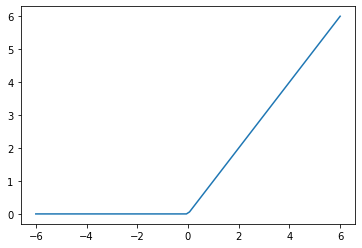

In [19]:
x = np.linspace(-6, 6, 100)

# convert from Var to ndarray  
def Var_to_nparray(x):
  y = np.zeros((len(x),len(x[0])))
  for i in range(len(x)):
    for j in range(len(x[0])):
      y[i,j] = x[i][j].v
  return y

# define 1-1 network with weight = 1 and relu activation 
NN = [ DenseLayer(1, 1, lambda x: x.relu(), initializer = ConstantInitializer(1.0)) ] 
y = Var_to_nparray(forward(nparray_to_Var(x), NN))

#y = Var_to_nparray(relu(nparray_to_Var(x)))
plt.plot(x,y)
plt.show()

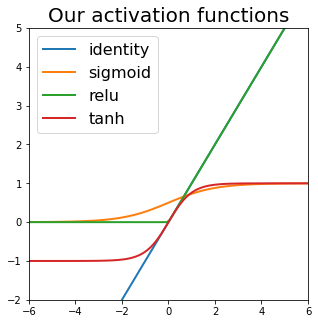

In [20]:
# Testing all activation layers

x = np.linspace(-6, 6, 100)
units = {
    "identity": lambda x: x.identity(),
    "sigmoid": lambda x: x.sigmoid(), 
    "relu": lambda x: x.relu(),
    "tanh": lambda x: x.tanh() 
}

plt.figure(figsize=(5, 5))
[plt.plot(x, Var_to_nparray(forward(nparray_to_Var(x), [DenseLayer(1, 1, unit, initializer = ConstantInitializer(1.0))]) ), label=unit_name, lw=2) for unit_name, unit in units.items()] # unit(nparray_to_Var(x))), label=unit_name, lw=2) for unit_name, unit in units.items()]
plt.legend(loc=2, fontsize=16)
plt.title('Our activation functions', fontsize=20)
plt.ylim([-2, 5])
plt.xlim([-6, 6])
plt.show()


# Advanced initialization schemes

If we are not careful with initialization, the signals we propagate forward ($a^{(l)}$, $l=1,\ldots,L$) and backward ($\delta^l$, $l=L,L-1,\ldots,1$) can blow up or shrink to zero. A statistical analysis of the variance of the signals for different activation functions can be found in these two papers: [Glorot initialization](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf) and [He initialization](https://arxiv.org/pdf/1502.01852v1.pdf). 

The result of the analyses are proposals for how to make the initialization such that the variance of the signals (forward and backward) are kept approxmimatly constant when propagating from layer to layer. The exact expressions depend upon the non-linear activation function used. In Glorot initialization, the aim is to keep both the forward and backward variances constant whereas He only aims at keeping the variance in the forward pass constant.

We define $n_{in}$ and $n_{out}$ as the number of input units and output units of a particular layer. 

The Glorot initialization has the form: 

$$w_{ij} \sim N \bigg( 0, \, \frac{2 \alpha }{n_{in} + n_{out}} \bigg) \ . $$

where $N(\mu,\sigma^2)$ is a Gaussian distribution with mean $\mu$ and variance $\sigma^2$ and $\alpha$ is a parameter that depends upon the activation function used. For $\tanh$, $\alpha=1$ and for Rectified Linear Unit (ReLU) activations, $\alpha=2$. (It is also possible to use a uniform distribution for initialization, see [this blog post](https://mmuratarat.github.io/2019-02-25/xavier-glorot-he-weight-init).) 

The He initialization is very similar

$$w_{ij} \sim N \bigg( 0, \, \frac{\alpha}{n_{in}} \bigg) \ . $$

## Exercise i) Glorot and He initialization
 
Using the Initializer class, implement functions that implement Glorot and He 

Explain briefly how you would test numerically that these initializations have the sought after property. Hint: See plots in Glorot paper.

Comment: If you want to be more advanced then try to make a universal initializer taking both the activation function and type (Glorot or He) as argument.

In [21]:
## Glorot
def DenseLayer_Glorot_tanh(n_in: int, n_out: int):
    alfa=1
    std = 2*alfa/(n_in + n_out) # <- replace with proper initialization
    return DenseLayer(n_in, n_out, lambda x: x.tanh(), initializer = NormalInitializer(std))

## He
def DenseLayer_He_relu(n_in: int, n_out: int):
    alfa=2
    std = alfa/(n_in)# <- replace with proper initialization
    return DenseLayer(n_in, n_out, lambda x: x.relu(), initializer = NormalInitializer(std))

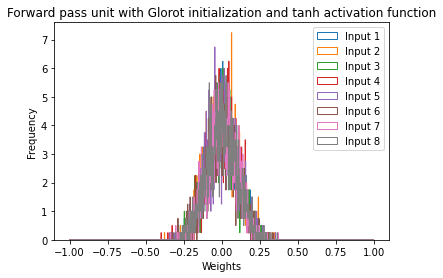

In [73]:
layer = DenseLayer_Glorot_tanh(8, 2000)

for ind,w in enumerate(layer.weights):
    p = [x.v for x in w] 
    i=ind+1
    plt.hist(p, bins=np.linspace(-1, 1, 1000),density=True,histtype='step',label='Input %i' % i) 

plt.legend()
plt.title('Forward pass unit with Glorot initialization and tanh activation function')
plt.xlabel('Weights')
plt.ylabel('Frequency') 
plt.show()


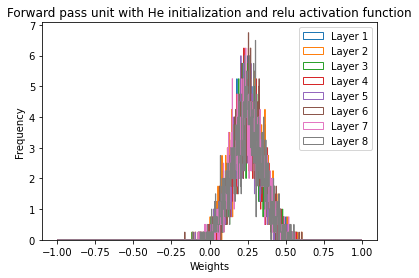

In [31]:
layer = DenseLayer_He_relu(8, 2000)

for ind,w in enumerate(layer.weights):
    p = [x.v for x in w]  
    i=ind+1
    plt.hist(p, bins=np.linspace(-1, 1, 1000), histtype='step', density=True,label='Input %i' % i)  
    
plt.legend()
plt.title('Forward pass unit with He initialization and relu activation function')
plt.xlabel('Weights')
plt.ylabel('Frequency') 
plt.show()

<span style="color:darkblue"> The aim of using different initialitzations schemes relies on keeping approximately constant the variance of the signals when propagating from layer to layer. The idea is to initialize each weight with a small Gaussian value with mean = 0.0 and variance based on the fan-in and fan-out of the weight. In both cases, the weights are mantained relatively constant for each input. 
Thus, this proper initialization would avoid reducing or magnifying the magnitudes of input signals exponentially as we need the variance of the outputs of each layer to be equal to the variance of its inputs. Then, we also need the gradients to have equal variance before and after flowing through a layer in the reverse direction.
    
    
<span style="color:darkblue">To sum up, Glorot Initialization is used to maintain the same smooth distribution for both the forward pass as well the backpropagation. As Glorot Initialization fails for ReLU, instead we use He Initialization for ReLU. 


</span>

## Exercise j) Forward pass unit test

Write a bit of code to make a unit test that the forward pass works. This can be done by defining a simple network with for example all weights equal to one (using the ConstantInitializer method) and identity activation functions. 

Hints: Use the [assert](https://www.w3schools.com/python/ref_keyword_assert.asp), the nparray_to_Var and the Var_to_nparray commands. 

In [32]:
# Insert code here
layer = DenseLayer(1, 1, lambda x: x.identity(), initializer=ConstantInitializer())
print(layer)

x = np.array([float(i) for i in range(25)])
y = Var_to_nparray(forward(nparray_to_Var(x), NN))

print('NN Inputs:',x)
print('NN Ouputs',y.T)


Weights: [[Var(v=1.0000, grad=0.0000)]] Biases: [Var(v=0.0000, grad=0.0000)]
NN Inputs: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24.]
NN Ouputs [[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
  18. 19. 20. 21. 22. 23. 24.]]


<span style="color:darkblue"> A simple network has been defined with all weights equal to one. As we have one input neuron and an output one, there is just one weight equal 1.0 and one neuron referring to the bias (in this case, equal 0). 
Due to using the identity activation function, the inputs are passed through the network, obtaining the same input responses as outputs. 
    
</span>

# Loss functions

We are only missing a loss function to we need to define a loss function and its derivative with respect to the output of the neural network $y$

In [33]:
def squared_loss(t, y):
  # add check that sizes agree
  def squared_loss_single(t, y):
    Loss = Var(0.0)
    for i in range(len(t)): # sum over outputs
      Loss += (t[i]-y[i]) ** 2
    return Loss

  Loss = Var(0.0)
  for n in range(len(t)): # sum over training data
    Loss += squared_loss_single(t[n],y[n])
  return Loss

## Exercise j) Implement cross entropy loss

Insert code below to implement cross-entropy loss for general dimensionality of $t$. Use a logits formulation:
$$
\rm{Loss} = - \sum_i t_i \, log \, p_i 
$$
with $p$ given by the the softmax function in terms of the logits $h$:
$$
p_i = \frac{\exp(h_i)}{\sum_{i'} \exp(h_{i'})} .
$$
Inserting $p$ in the expression for the loss gives
$$
\rm{Loss} = - \sum_i t_i h_i + \rm{LogSumExp}(h) \ ,
$$
where 
$$
\rm{LogSumExp}(h) = \log \sum_i \exp h_i \ .
$$
This is true for $t$ being a one-hot vector. 

Call the function to convince yourself it works. 

In practice you want to implement a [numerically stable](https://leimao.github.io/blog/LogSumExp/) version of LogSumExp. But we will not bother about that here.

Help: You can add these methods in the Var class:

    def exp(self):
        return Var(exp(self.v), lambda: [(self, exp(self.v))])
    
    def log(self):
        return Var(log(self.v), lambda: [(self, self.v ** -1)])

In [34]:
class Var:
    """
    A variable which holds a float and enables gradient computations.
    """

    def __init__(self, val: float, grad_fn=lambda: []):
        assert type(val) == float
        self.v = val
        self.grad_fn = grad_fn
        self.grad = 0.0

    def backprop(self, bp):
        self.grad += bp
        for input, grad in self.grad_fn():
            input.backprop(grad * bp)

    def backward(self):
        self.backprop(1.0)

    def __add__(self: 'Var', other: 'Var') -> 'Var':
        return Var(self.v + other.v, lambda: [(self, 1.0), (other, 1.0)])

    def __mul__(self: 'Var', other: 'Var') -> 'Var':
        #One variables takes the value of the other one as the gradient. 
        return Var(self.v * other.v, lambda: [(self, other.v), (other, self.v)]) 

    def __pow__(self, power):
        assert type(power) in {float, int}, "power must be float or int"
        return Var(self.v ** power, lambda: [(self, power * self.v ** (power - 1))])

    def __neg__(self: 'Var') -> 'Var':
        return Var(-1.0) * self

    def __sub__(self: 'Var', other: 'Var') -> 'Var':
        return self + (-other)

    def __truediv__(self: 'Var', other: 'Var') -> 'Var':
        return self * other ** -1

    def __repr__(self):
        return "Var(v=%.4f, grad=%.4f)" % (self.v, self.grad)

    def relu(self):
        return Var(self.v if self.v > 0.0 else 0.0, lambda: [(self, 1.0 if self.v > 0.0 else 0.0)])

    #ADDED ACTIVATION FUNCTIONS
    def identity(self):
        return Var(self.v, lambda: [(self, 1.0)])

    def tanh(self):
        return Var(tanh(self.v), lambda: [(self, 1 - tanh(self.v)**2)])
    
    def sigmoid(self):
        return Var(1/(1+exp(-self.v)) , lambda: [(self, (1/(1.0+exp(-self.v))) * (1 - 1/(1.0+exp(-self.v))))])
    
    def exp(self):
        return Var(exp(self.v), lambda: [(self, exp(self.v))])

    def log(self):
        return Var(log(self.v), lambda: [(self, self.v ** -1)])
    

In [35]:
def cross_entropy_loss(t, h):
     
    Loss = Var(0.0)
    for i in range(len(t)): 
        log_sum=Var(0.0)
        for k in range(len(h)):
            log_sum+=h[i].exp()
        log_sum=log_sum.log()
        Loss+=t[i]*h[i]+log_sum
    return -Loss

# Backward pass

Now the magic happens! We get the calculation of the gradients for free. Just do:

In [36]:
NN = [
    DenseLayer(1, 5, lambda x: x.relu()),
    DenseLayer(5, 1, lambda x: x.identity())
]

output = forward(x_train, NN)

Loss = squared_loss(y_train,output)
Loss.backward()

and the gradients will be calculated:

In [37]:
[print('Layer', i, '\n', NN[i]) for i in range(len(NN))] 

Layer 0 
 Weights: [[Var(v=-0.0947, grad=-2.7411), Var(v=0.0890, grad=-18.3751), Var(v=0.1184, grad=-13.6529), Var(v=-0.0511, grad=17.9838), Var(v=0.0632, grad=10.3059)]] Biases: [Var(v=0.0000, grad=2.4912), Var(v=0.0000, grad=-15.7928), Var(v=0.0000, grad=-11.7342), Var(v=0.0000, grad=-16.3443), Var(v=0.0000, grad=8.8576)]
Layer 1 
 Weights: [[Var(v=0.0288, grad=9.0237)], [Var(v=0.1862, grad=-8.7808)], [Var(v=0.1383, grad=-11.6884)], [Var(v=-0.1887, grad=4.8729)], [Var(v=-0.1044, grad=-6.2383)]] Biases: [Var(v=0.0000, grad=1.7987)]


[None, None]

# Backward pass unit test

Above we used finite differences to test that Nanograd is actually doing what it is supposed to do. We can in principle try the same for the neural network. But we will trust that the test above is enough.

# Training and validation

We are ready to train some neural networks!

We initialize again:

In [38]:
NN = [
    DenseLayer(1, 15, lambda x: x.relu()),
    DenseLayer(15, 50, lambda x: x.relu()),
    DenseLayer(50, 1, lambda x: x.identity())
]

output = forward(x_train, NN)

Loss = squared_loss(y_train,output)
Loss.backward()

and make an update:

We introduce a help function parameters to have a handle in all parameters in the network.

In [39]:
print('Network before update:')
[print('Layer', i, '\n', NN[i]) for i in range(len(NN))] 

def parameters(network):
  params = []
  for layer in range(len(network)):
    params += network[layer].parameters()
  return params

def update_parameters(params, learning_rate=0.01):
  for p in params:
    p.v -= learning_rate*p.grad

def zero_gradients(params):
  for p in params:
    p.grad = 0.0

update_parameters(parameters(NN))

print('\nNetwork after update:')
[print('Layer', i, '\n', NN[i]) for i in range(len(NN))] 

zero_gradients(parameters(NN))

print('\nNetwork after zeroing gradients:')
[print('Layer', i, '\n', NN[i]) for i in range(len(NN))] 

Network before update:
Layer 0 
 Weights: [[Var(v=-0.1541, grad=-4.6009), Var(v=0.0958, grad=-3.4083), Var(v=-0.0040, grad=-6.5134), Var(v=-0.1200, grad=-1.3975), Var(v=-0.0172, grad=0.5361), Var(v=-0.1193, grad=0.8019), Var(v=0.0174, grad=-0.0017), Var(v=0.0033, grad=-1.8967), Var(v=-0.0190, grad=-5.5864), Var(v=-0.0433, grad=-5.2356), Var(v=0.0655, grad=9.1416), Var(v=0.0287, grad=-9.2383), Var(v=0.0140, grad=-3.1086), Var(v=-0.1177, grad=1.2628), Var(v=-0.0831, grad=-5.9812)]] Biases: [Var(v=0.0000, grad=4.1831), Var(v=0.0000, grad=-2.9277), Var(v=0.0000, grad=5.9220), Var(v=0.0000, grad=1.2706), Var(v=0.0000, grad=-0.4874), Var(v=0.0000, grad=-0.7291), Var(v=0.0000, grad=-0.0015), Var(v=0.0000, grad=-1.6292), Var(v=0.0000, grad=5.0792), Var(v=0.0000, grad=4.7602), Var(v=0.0000, grad=7.8527), Var(v=0.0000, grad=-7.9358), Var(v=0.0000, grad=-2.6703), Var(v=0.0000, grad=-1.1481), Var(v=0.0000, grad=5.4381)]
Layer 1 
 Weights: [[Var(v=-0.1240, grad=0.0000), Var(v=-0.0944, grad=0.0000),

[None, None, None]

In [41]:
# Initialize an arbitrary neural network
NN = [
    DenseLayer(1, 8, lambda x: x.relu()),
    DenseLayer(8, 1, lambda x: x.identity())
]

# Recommended hyper-parameters for 3-D: 
#NN = [
#    DenseLayer(3, 16, lambda x: x.relu()),
#    DenseLayer(16, 1, lambda x: x.identity())
#]


### Notice that, when we switch from tanh to relu activation, we decrease the learning rate. This is due the stability of the gradients 
## of the activation functions.

In [40]:
# Initialize training hyperparameters
EPOCHS = 200
LEARN_R = 2e-3 

In [42]:
train_loss = []
val_loss = []

for e in range(EPOCHS):
     
    # Forward pass and loss computation
    Loss = squared_loss(y_train, forward(x_train, NN))

    # Backward pass
    Loss.backward()
    
    # gradient descent update
    update_parameters(parameters(NN), LEARN_R)
    zero_gradients(parameters(NN))
    
    # Training loss
    train_loss.append(Loss.v)
    
    # Validation
    Loss_validation = squared_loss(y_validation, forward(x_validation, NN))
    val_loss.append(Loss_validation.v)
    
    if e%10==0:
        print("{:4d}".format(e),
              "({:5.2f}%)".format(e/EPOCHS*100), 
              "Train loss: {:4.3f} \t Validation loss: {:4.3f}".format(train_loss[-1], val_loss[-1]))
        


   0 ( 0.00%) Train loss: 108.703 	 Validation loss: 106.384
  10 ( 5.00%) Train loss: 30.141 	 Validation loss: 20.652
  20 (10.00%) Train loss: 14.380 	 Validation loss: 10.721
  30 (15.00%) Train loss: 13.977 	 Validation loss: 10.456
  40 (20.00%) Train loss: 13.627 	 Validation loss: 10.222
  50 (25.00%) Train loss: 13.159 	 Validation loss: 9.920
  60 (30.00%) Train loss: 12.720 	 Validation loss: 9.625
  70 (35.00%) Train loss: 12.400 	 Validation loss: 9.398
  80 (40.00%) Train loss: 12.227 	 Validation loss: 9.278
  90 (45.00%) Train loss: 12.097 	 Validation loss: 9.178
 100 (50.00%) Train loss: 12.011 	 Validation loss: 9.150
 110 (55.00%) Train loss: 11.959 	 Validation loss: 9.139
 120 (60.00%) Train loss: 11.930 	 Validation loss: 9.128
 130 (65.00%) Train loss: 11.913 	 Validation loss: 9.108
 140 (70.00%) Train loss: 11.904 	 Validation loss: 9.092
 150 (75.00%) Train loss: 11.899 	 Validation loss: 9.078
 160 (80.00%) Train loss: 11.896 	 Validation loss: 9.068
 170 (8

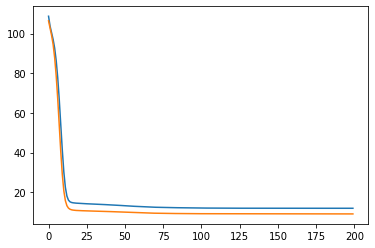

In [43]:
plt.plot(range(len(train_loss)), train_loss);
plt.plot(range(len(val_loss)), val_loss);

# Testing

We have kept the calculation of the test error separate in order to emphasize that you should not use the test set in optimization.

In [44]:
output_test = forward(x_test, NN)

Test loss:  9.834


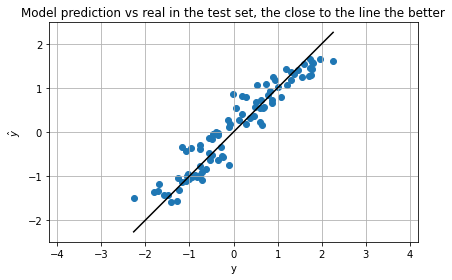

In [45]:
y_test_np = Var_to_nparray(y_test)
plt.scatter(y_test_np, Var_to_nparray(output_test));
plt.plot([np.min(y_test_np), np.max(y_test_np)], [np.min(y_test_np), np.max(y_test_np)], color='k');
plt.xlabel("y");
plt.ylabel("$\hat{y}$");
plt.title("Model prediction vs real in the test set, the close to the line the better")
plt.grid(True);
plt.axis('equal');
plt.tight_layout();

Loss_test = squared_loss(y_test, forward(x_test, NN))

print("Test loss:  {:4.3f}".format(Loss_test.v))

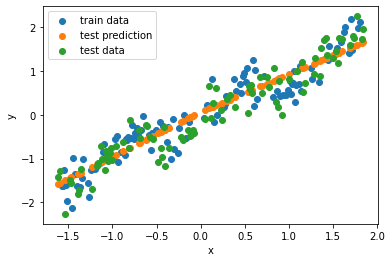

In [46]:
x_test_np = Var_to_nparray(x_test)
x_train_np = Var_to_nparray(x_train)
y_train_np = Var_to_nparray(y_train)
if D1:
    plt.scatter(x_train_np, y_train_np, label="train data");
    plt.scatter(x_test_np, Var_to_nparray(output_test), label="test prediction");
    plt.scatter(x_test_np, y_test_np, label="test data");
    plt.legend();
    plt.xlabel("x");
    plt.ylabel("y");
else:
    plt.scatter(x_train_np[:,1], y_train, label="train data");
    plt.scatter(x_test_np[:,1], Var_to_nparray(output_test), label="test data prediction");
    plt.scatter(x_test_np[:,1], y_test_np, label="test data");
    plt.legend();
    plt.xlabel("x");
    plt.ylabel("y");

## Exercise k) Show overfitting, underfitting and just right fitting

Vary the architecture and other things to show clear signs of overfitting (=training loss significantly lower than test loss) and underfitting (=not fitting enoung to training data so that test performance is also hurt).

See also if you can get a good compromise which leads to a low validation loss. 

For this problem do you see any big difference between validation and test loss? The answer here will probably be no. Discuss cases where it is important to keep the two separate.

<span style="color:darkblue"> Above it can be seen the results obtained when overfitting and the underfitting the neural network. 
    
<span style="color:darkblue"> - We can see **overfitting** when the algorithm models the data too well. It happens when the model learns detail and noise in the training data to the extent that it negatively impacts the performance of the model on new data. This can take place when increasing too much the number of epochs that the model learns a lot from the data it has. In this case, the training loss should be much less than the test loss. 
    
<span style="color:darkblue"> - On the other hand, the **underfitting** is a situation when your model is too simple for your data with such a high bias. The model can not do accurate predictions. To model that, few epochs are being used so that the model is too simple to make accurate decisions. In this case, train error is large and val/test error is large too as shown in the model below. 
    
    
<span style="color:darkblue"> Finally, I am not seeing too much difference between the validation and test loss due to this specific data set. It is crucial to separate them since the validation test is used to optimize model parameters and performance by fine-tuning the model after each epoch while the test set gets an estimate of the final model performance. 
</span>


 

### k.a) Overfitting

In [86]:
# We Initialize an arbitrary neural network
NN = [
    DenseLayer(1, 15, lambda x: x.relu()),
    DenseLayer(15, 1, lambda x: x.identity())
]

EPOCHS = 5000
LEARN_R = 2e-5 

train_loss = []
val_loss = []


for e in range(EPOCHS):
     
    # Forward pass and loss computation
    Loss = squared_loss(y_train, forward(x_train, NN))

    # Backward pass
    Loss.backward()
    
    # gradient descent update
    update_parameters(parameters(NN), LEARN_R)
    zero_gradients(parameters(NN))
    
    # Training loss
    train_loss.append(Loss.v)
    
    # Validation
    Loss_validation = squared_loss(y_validation, forward(x_validation, NN))
    val_loss.append(Loss_validation.v)
    
    if e%50==0:
        print("{:4d}".format(e),
              "({:5.2f}%)".format(e/EPOCHS*100), 
              "Train loss: {:4.3f} \t Validation loss: {:4.3f}".format(train_loss[-1], val_loss[-1]))

    

   0 ( 0.00%) Train loss: 99.095 	 Validation loss: 102.630
  50 ( 1.00%) Train loss: 94.971 	 Validation loss: 98.554
 100 ( 2.00%) Train loss: 90.704 	 Validation loss: 94.305
 150 ( 3.00%) Train loss: 86.171 	 Validation loss: 89.762
 200 ( 4.00%) Train loss: 81.160 	 Validation loss: 84.727
 250 ( 5.00%) Train loss: 75.667 	 Validation loss: 79.188
 300 ( 6.00%) Train loss: 69.678 	 Validation loss: 73.146
 350 ( 7.00%) Train loss: 63.277 	 Validation loss: 66.633
 400 ( 8.00%) Train loss: 56.604 	 Validation loss: 59.758
 450 ( 9.00%) Train loss: 49.890 	 Validation loss: 52.745
 500 (10.00%) Train loss: 43.408 	 Validation loss: 45.859
 550 (11.00%) Train loss: 37.401 	 Validation loss: 39.363
 600 (12.00%) Train loss: 32.070 	 Validation loss: 33.482
 650 (13.00%) Train loss: 27.542 	 Validation loss: 28.375
 700 (14.00%) Train loss: 23.853 	 Validation loss: 24.112
 750 (15.00%) Train loss: 20.966 	 Validation loss: 20.683
 800 (16.00%) Train loss: 18.789 	 Validation loss: 18.

Test loss:  10.253


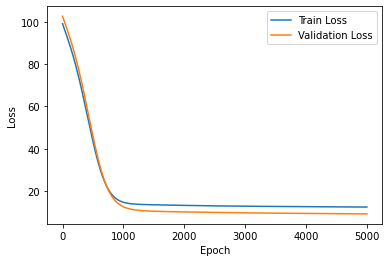

In [87]:
plt.plot(range(len(train_loss)), train_loss,label='Train Loss');
plt.plot(range(len(val_loss)), val_loss,label='Validation Loss');
plt.xlabel('Epoch')
plt.ylabel('Loss') 
plt.legend()

output_test = forward(x_test, NN)
Loss_test = squared_loss(y_test, forward(x_test, NN))
print("Test loss:  {:4.3f}".format(Loss_test.v))


### k.b) Underfitting

In [84]:
# We Initialize an arbitrary neural network
NN = [
    DenseLayer(1, 10, lambda x: x.relu()),
    DenseLayer(10, 1, lambda x: x.identity())
]

EPOCHS = 100
LEARN_R = 2e-5 

train_loss = []
val_loss = []


for e in range(EPOCHS):
     
    # Forward pass and loss computation
    Loss = squared_loss(y_train, forward(x_train, NN))

    # Backward pass
    Loss.backward()
    
    # gradient descent update
    update_parameters(parameters(NN), LEARN_R)
    zero_gradients(parameters(NN))
    
    # Training loss
    train_loss.append(Loss.v)
    
    # Validation
    Loss_validation = squared_loss(y_validation, forward(x_validation, NN))
    val_loss.append(Loss_validation.v)
    
    if e%20==0:
        print("{:4d}".format(e),
              "({:5.2f}%)".format(e/EPOCHS*100), 
              "Train loss: {:4.3f} \t Validation loss: {:4.3f}".format(train_loss[-1], val_loss[-1]))

    

   0 ( 0.00%) Train loss: 102.548 	 Validation loss: 104.935
  20 (20.00%) Train loss: 101.504 	 Validation loss: 103.967
  40 (40.00%) Train loss: 100.439 	 Validation loss: 102.969
  60 (60.00%) Train loss: 99.343 	 Validation loss: 101.932
  80 (80.00%) Train loss: 98.207 	 Validation loss: 100.846


Test loss:  92.543


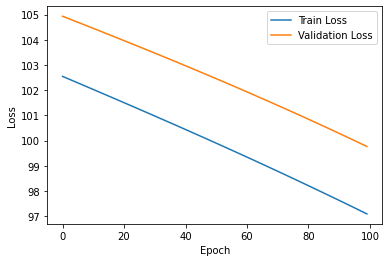

In [85]:
plt.plot(range(len(train_loss)), train_loss,label='Train Loss');
plt.plot(range(len(val_loss)), val_loss,label='Validation Loss');plt.xlabel('Epoch')
plt.ylabel('Loss') 
plt.legend()


plt.legend()

output_test = forward(x_test, NN)
Loss_test = squared_loss(y_test, forward(x_test, NN))
print("Test loss:  {:4.3f}".format(Loss_test.v))



# Next steps - classification

It is straight forward to extend what we have done to classification. 

For numerical stability it is better to make softmax and cross-entropy as one function so we write the cross entropy loss as a function of the logits we talked about last week. 

Next week we will see how to perform classification in PyTorch.

## Exercise l) optional - Implement backpropagation for classification

Should be possible with very few lines of code. :-)

In [ ]:
# Just add code.

## Exercise m) optional - Introduce a NeuralNetwork class

The functions we applied on the neural network (parameters, update_parameters and zero_gradients) can more naturally be included as methods in a NeuralNetwork class. Make such a class and modify the code to use it. 

In [ ]:
# just add some code